# Emulator Setup

In [22]:
# %matplotlib widget

In [23]:
# modified from test.ipynb and main.py

from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

from scse.api.simulation import run_simulation

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition

In [24]:
# Libraries for multiprocessing
from multiprocess.pool import Pool
from tqdm import tqdm

In [25]:
from loop import *

## miniSCOT Functions

In [26]:
def invoke_miniscot(x):
    """
    Handling single API call to miniSCOT simulation given some inputs

    x contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]
    """

    kwargs = {
        'time_horizon': 336,
        'num_batteries': int(x[0])
    }
    
    if len(x) == 2:
        kwargs.update({
            'battery_penalty': int(x[1])
        })
        
    cum_reward = run_simulation(**kwargs)
    
    return cum_reward[-1]

In [27]:
def f(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    Y = []
    for x in X:
        cum_reward = invoke_miniscot(x)

        # Note that we negate the reward; want to find min
        Y.append(-cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

In [28]:
def f_multiprocess(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs using multiprocessing.

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    
    # Set to None to use all available CPU
    max_pool = 4
    with Pool(max_pool) as p:
        Y = list(
            tqdm(
                p.imap(invoke_miniscot, X),
                total=X.shape[0]
            )
        )

    # Note that we negate the reward; want to find min
    Y = -np.reshape(np.array(Y), (-1, 1))
    return Y

## Plotting Functions

In [29]:
def plot_reward(X, Y, labels):
    """
    Plots reward against a maximum of two dimensions.
    """

    plt.style.use('seaborn')
    fig = plt.figure(figsize=(10,10))

    order = np.argsort(X[:,0])
    
    if X.shape[1] == 1:
        ax = plt.axes()
        ax.plot(X[order,0], Y[order])
        ax.set_xlabel(labels[0])
        ax.set_ylabel("Cumulative reward")
    elif X.shape[1] == 2:
        ax = plt.axes(projection='3d')
        im = ax.plot_trisurf(X[order,0].flatten(), X[order,1].flatten(), Y[order].flatten(), cmap=cm.get_cmap('autumn'))
        fig.colorbar(im)
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel("Cumulative reward")
    else:
        raise ValueError('X has too many dimensions to plot - max 2 allowed')

    return fig, ax

# Global Sensitivity Analysis

In [30]:
import pandas as pd
import mlai.plot as plot
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Comparing Rel. Sensitivity of No. Batteries to Max Battery Capacities

In [20]:
max_num_batteries = 1000
min_battery_capacity = 50
max_battery_capacity = 150
min_battery_penalty = -(25 * 1000)
max_battery_penalty = -(250 * 1000)
num_data_points = 5

timsteps_per_week = 336
num_weeks = 52

In [21]:
num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1, 10))
battery_penalty = DiscreteParameter('battery_penalty', range(max_battery_penalty, min_battery_penalty))
time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])

# parameter_space = ParameterSpace([num_batteries])
parameter_space = ParameterSpace([num_batteries, max_battery_capacities])

design = RandomDesign(parameter_space)

X = design.get_samples(num_data_points)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.04s/it]


(<Figure size 720x720 with 2 Axes>,
 <Axes3DSubplot:xlabel='num_batteries', ylabel='max_battery_capacity'>)

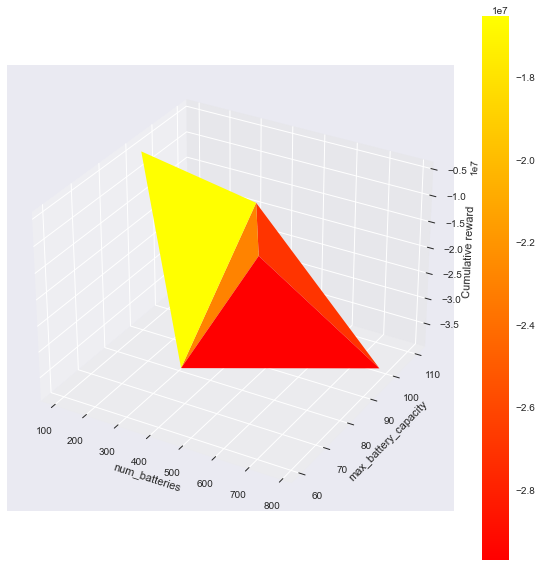

In [22]:
# Get initial points
Y = f_multiprocess(X)
plot_reward(X, Y, parameter_space.parameter_names)

In [23]:
# RUN EMULATOR

successful_sample = False
num_tries = 0
max_num_tries = 3

use_default= False
use_ard=False

while not successful_sample and num_tries < max_num_tries: 

    print(f"CURRENT ATTEMPT #{num_tries}")

    # emulator model

    if use_default: 
        gpy_model = GPRegression(X, Y)
    else: 
        kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=use_ard)
        gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)

    try: 
        gpy_model.optimize()
        print("okay to optimize")
        model_emukit = GPyModelWrapper(gpy_model)

        # Load core elements for Bayesian optimization
        expected_improvement = ExpectedImprovement(model=model_emukit)
        optimizer = GradientAcquisitionOptimizer(space=parameter_space)

        # Create the Bayesian optimization object
        batch_size = 3
        bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                 space=parameter_space,
                                                 acquisition=expected_improvement,
                                                 batch_size=batch_size)

        # Run the loop and extract the optimum;  we either complete 10 steps or converge
        max_iters = 10
        stopping_condition = (
            FixedIterationsStoppingCondition(i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)
        )

        bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
        print("successfully ran loop")
        successful_sample = True

    except: 
        num_tries += 1

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


CURRENT ATTEMPT #0
okay to optimize


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:03<00:00, 21.11s/it]
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optim

successfully ran loop


In [24]:
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

new_order = np.argsort(new_X[:,0])
new_X = new_X[new_order,:]
new_Y = new_Y[new_order]

NameError: name 'LEGEND_SIZE' is not defined

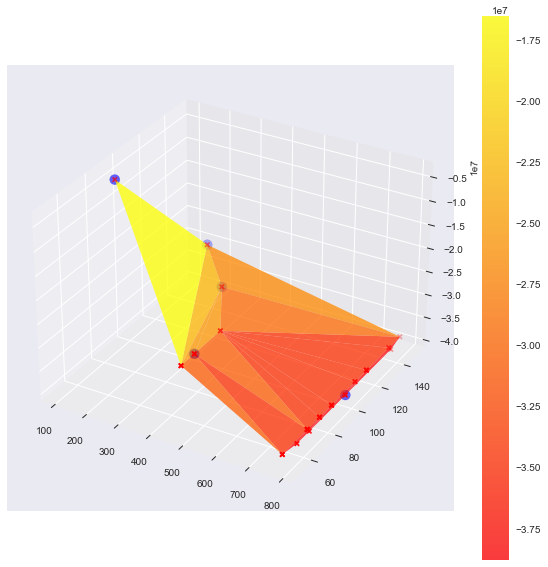

In [25]:
# PLOT INFERRED SURFACE

plt.style.use('seaborn')
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

im = ax.plot_trisurf(new_X[:,0].flatten(), new_X[:,1].flatten(), new_Y.flatten(), cmap=cm.get_cmap('autumn'), alpha=0.75)
fig.colorbar(im)

ax.scatter(X[:,0].flatten(), X[:,1].flatten(), Y.flatten(), s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:,0].flatten(), new_X[:,1].flatten(), new_Y.flatten(), marker="x", color="r", label="All observations")

ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_ylabel(r"$f(x)$")
ax.grid(True)

In [ ]:
num_mc = 10000
sensitivity = MonteCarloSensitivity(model = gpy_model, input_domain = parameter_space)
main_effects_gp, total_effects_gp, _ = sensitivity.compute_effects(num_monte_carlo_points = num_mc)

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

plt.plot()

# Analysing how Changing Battery Cost (Penalty) Changes The Recommended No. of Batteries

## SIMPLIFIED TEST

In [41]:
min_battery_capacity = 50
max_battery_capacity = 150
min_battery_penalty = -(25 * 1000)
max_battery_penalty = -(250 * 1000)
num_data_points = 10

timsteps_per_week = 336
num_weeks = 52

  0%|                                                                                                                                                                               | 0/6 [00:00<?, ?it/s]

[[      0 -350000]
 [     50 -350000]
 [    100 -350000]
 [    150 -350000]
 [    200 -350000]
 [    250 -350000]
 [    300 -350000]
 [    350 -350000]
 [    400 -350000]
 [    450 -350000]
 [    500 -350000]]



 17%|███████████████████████████▋                                                                                                                                          | 1/6 [02:35<12:56, 155.20s/it]

[0]


IndexError: list index out of range

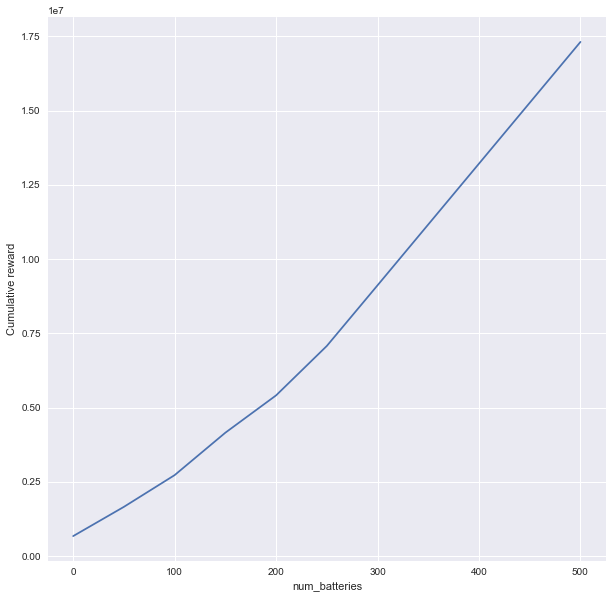

In [42]:
min_battery_results = []
#max_num_batteries_experiment = [500, 500, 800, 800, 4000, 6000]
#min_num_batteries_experiment = [100, 100, 100, 100, 2000, 4000]
max_num_batteries_experiment = [500]
min_num_batteries_experiment = [0]
#battery_penalties = [-350000, -300000, -250000, -200000, -150000, -100000]
battery_penalities = [-200000]

for i, penalty in enumerate(tqdm(battery_penalties)):
    max_num_batteries = max_num_batteries_experiment[i]
    
    num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
    max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1, 10))
    battery_penalty = DiscreteParameter('battery_penalty', range(max_battery_penalty, min_battery_penalty))
    time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])

    parameter_space = ParameterSpace([num_batteries])
    # parameter_space = ParameterSpace([num_batteries, battery_penalty])

    #design = RandomDesign(parameter_space)

    X = np.arange(min_num_batteries_experiment[i], max_num_batteries_experiment[i]+1, 
                  int((max_num_batteries_experiment[i]-min_num_batteries_experiment[i])/num_data_points))
        
    X = np.array([[n]for n in X])
    
    # Add column to specify the battery penalty
    X = np.insert(X, 1, battery_penalties[i], axis=1)
    
    # Get initial points
    Y = f_multiprocess(X)
    
    # Fix X, as in remove the column added above that specifies the battery penalty
    X = np.delete(X, 1, 1)
    
    plot_reward(X, Y, parameter_space.parameter_names)
    
    min_battery_results.append(int(X[min(range(len(X)), key=Y.__getitem__)][0]))
    print(min_battery_results)

### Search over higher num_battery vals for later results

In [134]:
def invoke_miniscot(x):
    """
    Handling single API call to miniSCOT simulation given some inputs

    x contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]
    """

    kwargs = {
        'time_horizon': 336,
        'num_batteries': int(x[0])
    }
    
    if len(x) == 2:
        kwargs.update({
            'battery_penalty': int(x[1])
        })
        
    cum_reward = run_simulation(**kwargs)
    
    return cum_reward[-1]

In [135]:
min_battery_capacity = 50
max_battery_capacity = 150
min_battery_penalty = -(25 * 1000)
max_battery_penalty = -(250 * 1000)
num_data_points = 10

timsteps_per_week = 336
num_weeks = 52

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:36<00:00, 33.65s/it]

[3800]


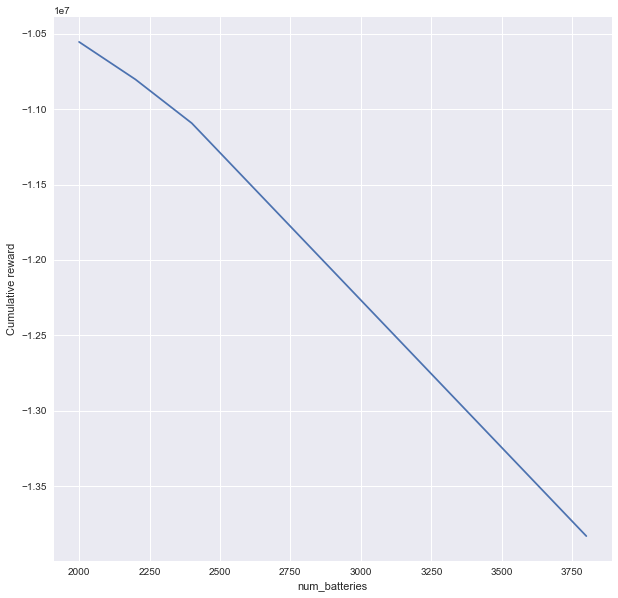

In [136]:
min_battery_results = []
max_num_batteries_experiment = [1000, 1000, 1000, 1000, 2000, 3000, 6000, 12000]
battery_penalties = [-400000, -350000, -300000, -250000, -200000, -150000, -100000, -50000]
    
num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1, 10))
battery_penalty = DiscreteParameter('battery_penalty', range(max_battery_penalty, min_battery_penalty))
time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])

parameter_space = ParameterSpace([num_batteries])
# parameter_space = ParameterSpace([num_batteries, battery_penalty])

#design = RandomDesign(parameter_space)

X = np.arange(2000, 4000, 200)
X = np.array([[n]for n in X])

# Add column to specify the battery penalty
X = np.insert(X, 1, -200000, axis=1)

# Get initial points
Y = f_multiprocess(X)

# Fix X, as in remove the column added above that specifies the battery penalty
X = np.delete(X, 1, 1)

plot_reward(X, Y, parameter_space.parameter_names)

min_battery_results.append(int(X[min(range(len(X)), key=Y.__getitem__)][0]))
print(min_battery_results)

## INITIAL SINGLE RUN TEST/CELLS

In [49]:
max_num_batteries = 6000
min_battery_capacity = 50
max_battery_capacity = 150
min_battery_penalty = -(25 * 1000)
max_battery_penalty = -(250 * 1000)
num_data_points = 5

timsteps_per_week = 336
num_weeks = 52

In [50]:
num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1, 10))
battery_penalty = DiscreteParameter('battery_penalty', range(max_battery_penalty, min_battery_penalty))
time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])

parameter_space = ParameterSpace([num_batteries])
# parameter_space = ParameterSpace([num_batteries, battery_penalty])

design = RandomDesign(parameter_space)

X = design.get_samples(num_data_points)

# Add column to specify the battery penalty
X = np.insert(X, 1, -100000, axis=1)

In [51]:
# Get initial points
Y = f_multiprocess(X)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:01<00:00, 24.28s/it]


In [52]:
# Fix X, as in remove the column added above that specifies the battery penalty
X = np.delete(X, 1, 1)

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='num_batteries', ylabel='Cumulative reward'>)

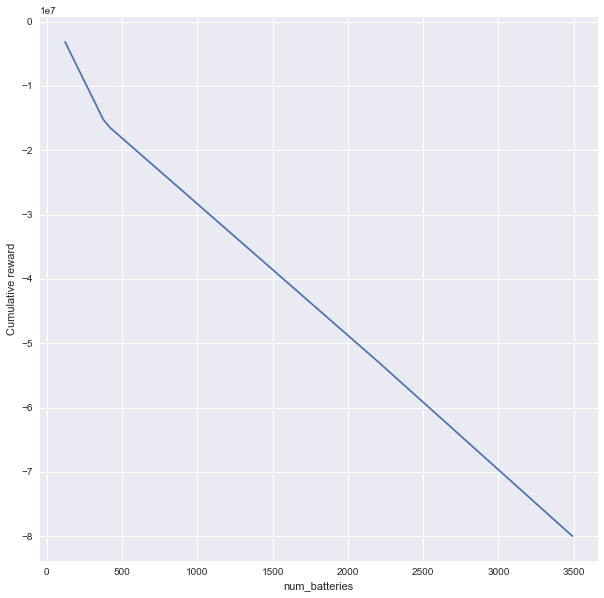

In [53]:
plot_reward(X, Y, parameter_space.parameter_names)

In [54]:
# RUN EMULATOR

successful_sample = False
num_tries = 0
max_num_tries = 3

use_default= False
use_ard=False

while not successful_sample and num_tries < max_num_tries: 

    print(f"CURRENT ATTEMPT #{num_tries}")

    # emulator model

    if use_default: 
        gpy_model = GPRegression(X, Y)
    else: 
        kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=use_ard)
        gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)

    try: 
        gpy_model.optimize()
        print("okay to optimize")
        model_emukit = GPyModelWrapper(gpy_model)

        # Load core elements for Bayesian optimization
        expected_improvement = ExpectedImprovement(model=model_emukit)
        optimizer = GradientAcquisitionOptimizer(space=parameter_space)

        # Create the Bayesian optimization object
        batch_size = 3
        bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                 space=parameter_space,
                                                 acquisition=expected_improvement,
                                                 batch_size=batch_size)

        # Run the loop and extract the optimum;  we either complete 10 steps or converge
        max_iters = 10
        stopping_condition = (
            FixedIterationsStoppingCondition(i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)
        )

        bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
        print("successfully ran loop")
        successful_sample = True

    except: 
        num_tries += 1

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


CURRENT ATTEMPT #0


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


okay to optimize


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


CURRENT ATTEMPT #1
okay to optimize


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)
  0%|                                                                                                                                                                               | 0/3 [00:34<?, ?it/s]Process ForkPoolWorker-63:
Process ForkPoolWorker-62:
Process ForkPoolWorker-61:
Process ForkPoolWorker-64:

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood

CURRENT ATTEMPT #2
okay to optimize


In [55]:
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

new_order = np.argsort(new_X[:,0])
new_X = new_X[new_order,:]
new_Y = new_Y[new_order]

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:xlabel='num_batteries', ylabel='Cumulative reward'>)

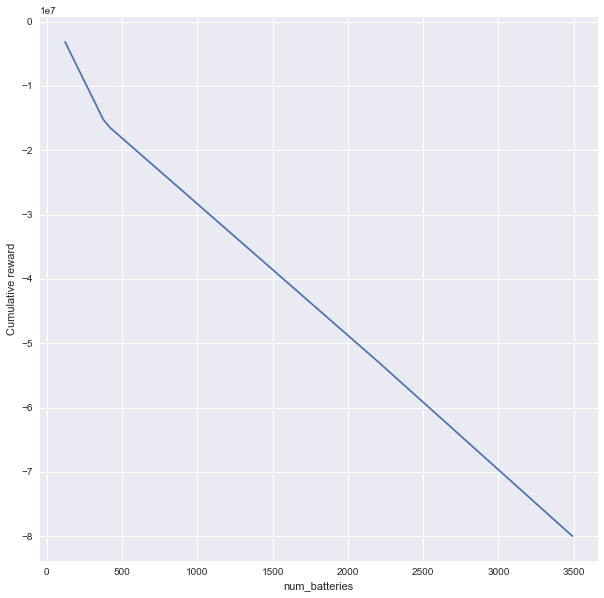

In [56]:
plot_reward(new_X, new_Y, parameter_space.parameter_names)

In [57]:
x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1,1))
mu_plot, var_plot = model_emukit.predict(x_plot)

plt.figure(figsize=(12, 8))
#plt.figure(figsize=(7, 5))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
# plt.xlim(0, 25)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff840cf7ee0> (for post_execute):


KeyboardInterrupt: 

## MAIN EXPERIMENT

In [64]:
# Define ultimate values needed

initial_optimal_n_batteries = np.array([])
initial_mwh_cost = np.array(range(-300000, -49999, 50000))

In [65]:
initial_mwh_cost

array([-300000, -250000, -200000, -150000, -100000,  -50000])

In [83]:
# General Setup (for both emulators)

max_num_batteries = 1000
min_battery_capacity = 50
max_battery_capacity = 150
min_battery_penalty = -(25 * 1000)
max_battery_penalty = -(300000 * 1000)
num_data_points = 10

timsteps_per_week = 336
num_weeks = 52

num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1, 10))
battery_penalty = DiscreteParameter('battery_penalty', range(max_battery_penalty, min_battery_penalty))
time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])

In [84]:
# Setup main emulator loop
parameter_space = ParameterSpace([battery_penalty])

X = initial_mwh_cost

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:43<00:00, 16.39s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


CURRENT ATTEMPT #0
okay to optimize


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:48<00:00, 16.14s/it]
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based opti

successfully ran loop


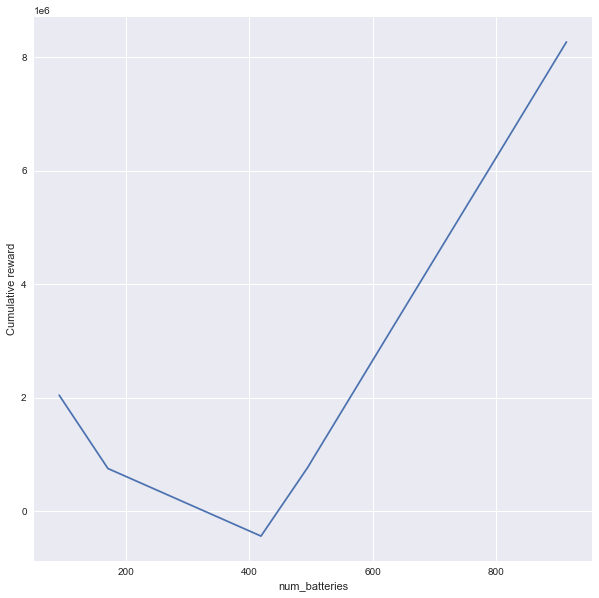

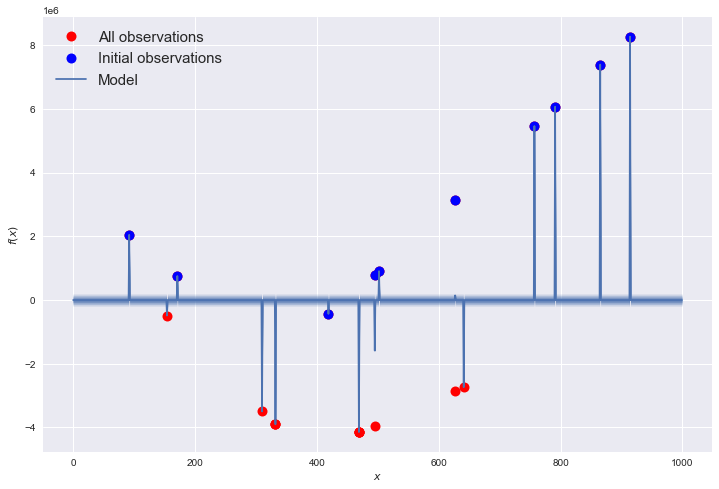

 17%|███████████████████████████▋                                                                                                                                          | 1/6 [06:35<32:58, 395.76s/it]

[469.]



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:43<00:00, 16.34s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


CURRENT ATTEMPT #0
okay to optimize


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:55<00:00, 18.44s/it]
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based opti

successfully ran loop


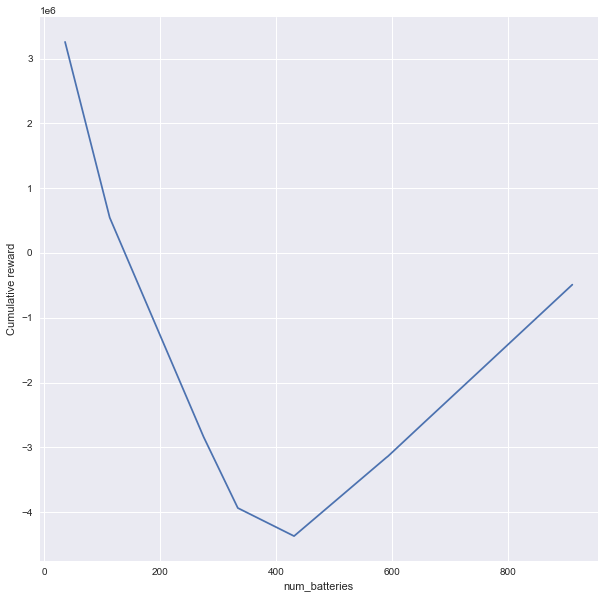

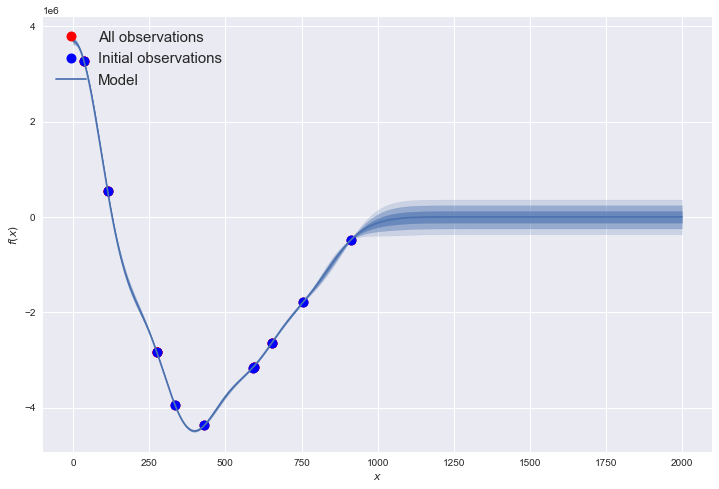

 33%|███████████████████████████████████████████████████████▎                                                                                                              | 2/6 [11:13<21:46, 326.54s/it]

[469. 431.]



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:10<00:00, 19.02s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


CURRENT ATTEMPT #0
okay to optimize


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:21<00:00, 27.28s/it]
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based opti

successfully ran loop


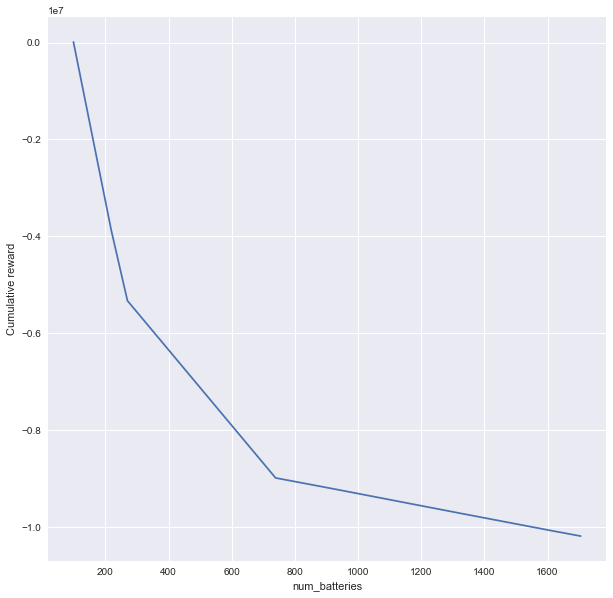

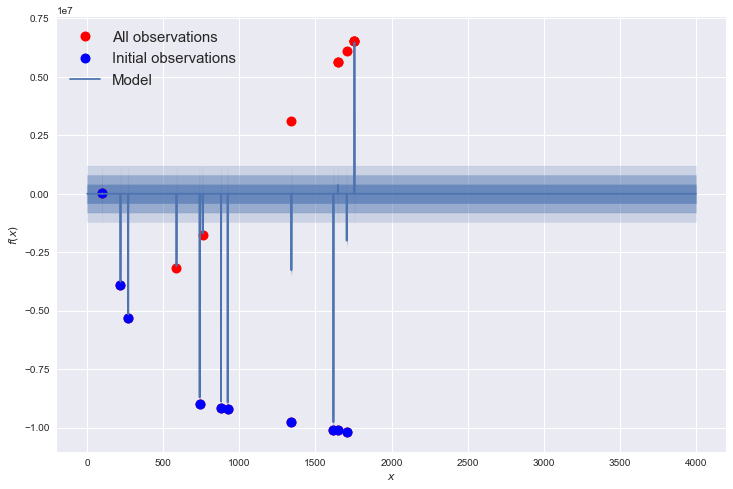

 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 3/6 [18:32<18:53, 377.72s/it]

[ 469.  431. 1705.]



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:28<00:00, 20.84s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


CURRENT ATTEMPT #0
okay to optimize


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:36<00:00, 32.22s/it]
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based opti

successfully ran loop


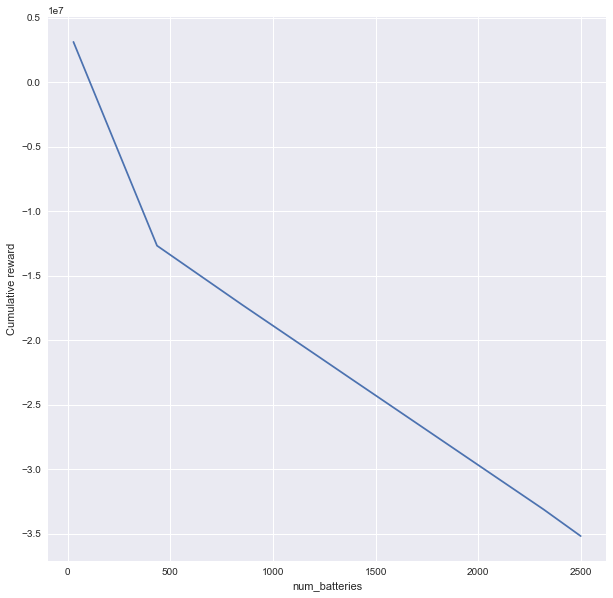

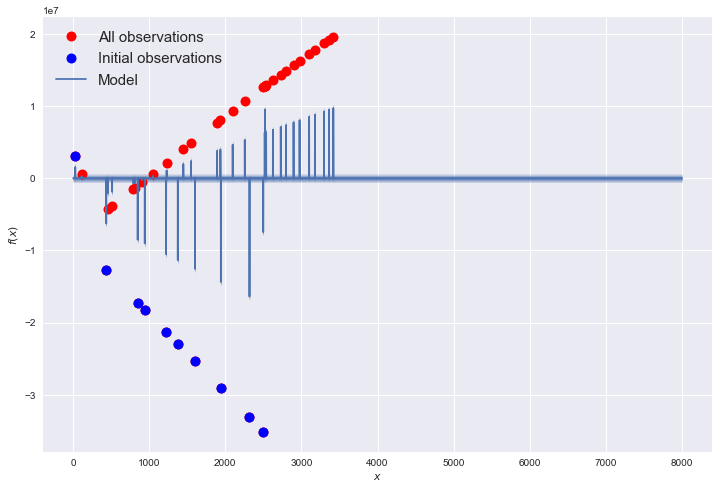

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 4/6 [39:58<24:32, 736.49s/it]

[ 469.  431. 1705. 2498.]



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 8/10 [05:54<01:28, 44.30s/it]Process ForkPoolWorker-253:
Process ForkPoolWorker-255:
Process ForkPoolWorker-254:
Process ForkPoolWorker-256:

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 4/6 [45:53<22:56, 688.39s/it]


KeyboardInterrupt: 

In [85]:
# Get initial 6 data points for main emulator loop
i = 1

for battery_penalty in tqdm(initial_mwh_cost):
    
    num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
    
    max_num_batteries = 1000 * i
    i *= 2
    parameter_space = ParameterSpace([num_batteries])

    design = RandomDesign(parameter_space)

    X = design.get_samples(num_data_points)
    
    # Add column to specify the battery penalty
    X = np.insert(X, 1, battery_penalty, axis=1)
    

    # Get initial points
    Y = f_multiprocess(X)
    
    
    # Fix X, as in remove the column added above that specifies the battery penalty
    X = np.delete(X, 1, 1)
    
    # Plot the initial data points
    plot_reward(X, Y, parameter_space.parameter_names)


    # Run Emulator
    successful_sample = False
    num_tries = 0
    max_num_tries = 3

    use_default= False
    use_ard=False

    while not successful_sample and num_tries < max_num_tries: 

        print(f"CURRENT ATTEMPT #{num_tries}")

        # emulator model

        if use_default: 
            gpy_model = GPRegression(X, Y)
        else: 
            kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=use_ard)
            gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)

        try: 
            gpy_model.optimize()
            print("okay to optimize")
            model_emukit = GPyModelWrapper(gpy_model)

            # Load core elements for Bayesian optimization
            expected_improvement = ExpectedImprovement(model=model_emukit)
            optimizer = GradientAcquisitionOptimizer(space=parameter_space)

            # Create the Bayesian optimization object
            batch_size = 3
            bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                     space=parameter_space,
                                                     acquisition=expected_improvement,
                                                     batch_size=batch_size)

            # Run the loop and extract the optimum;  we either complete 10 steps or converge
            max_iters = 10
            stopping_condition = (
                FixedIterationsStoppingCondition(i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)
            )

            bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
            print("successfully ran loop")
            successful_sample = True

        except: 
            num_tries += 1
            
    
    # Get new X and Y values
    new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

    new_order = np.argsort(new_X[:,0])
    new_X = new_X[new_order,:]
    new_Y = new_Y[new_order]
    
    # Plot the results of the emulation
    x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1,1))
    mu_plot, var_plot = model_emukit.predict(x_plot)

    plt.figure(figsize=(12, 8))
    #plt.figure(figsize=(7, 5))
    LEGEND_SIZE = 15
    plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
    plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
    # plt.plot(x_plot, y_plot, "k", label="Objective Function")
    plt.plot(x_plot, mu_plot, "C0", label="Model")
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

    plt.legend(loc=2, prop={'size': LEGEND_SIZE})
    plt.xlabel(r"$x$")
    plt.ylabel(r"$f(x)$")
    plt.grid(True)
    # plt.xlim(0, 25)
    plt.show()
    
    # Get optimal number of batteries
    min_n_batteries = int(new_X[min(range(len(new_X)), key=new_Y.__getitem__)][0])
    initial_optimal_n_batteries = np.append(initial_optimal_n_batteries, min_n_batteries)
    print(initial_optimal_n_batteries)

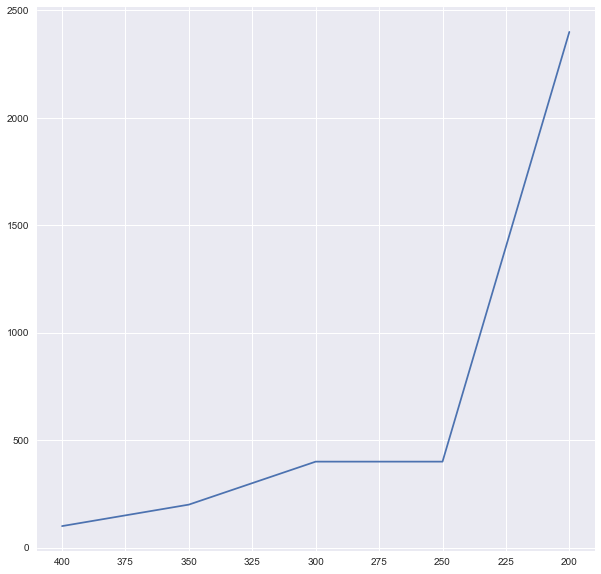

In [40]:
# Plot the no. of batteries the model recommends vs. the battery penalty

optimal_n_batteries = [100, 200, 400, 400, 2400]
battery_penalty = [400, 350, 300, 250, 200]

plt.style.use('seaborn')
fig = plt.figure(figsize=(10,10))

plt.gca().invert_xaxis()
plt.plot(battery_penalty, optimal_n_batteries)
plt.show()

## Check how changing lifetime years changes the recommended number of batteries

In [ ]:
def invoke_miniscot(x):
    """
    Handling single API call to miniSCOT simulation given some inputs

    x contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]
    """

    kwargs = {
        'time_horizon': 336,
        'num_batteries': int(x[0])
    }
    
    if len(x) == 2:
        kwargs.update({
            'lifetime_years': int(x[1])
        })
        
    cum_reward = run_simulation(**kwargs)
    
    return cum_reward[-1]

In [ ]:
# Define ultimate values needed

initial_optimal_n_batteries = np.array([])
initial_lifetime = np.array(range(5, -31, 5))

In [ ]:
# General Setup (for both emulators)

max_num_batteries = 1000
min_battery_capacity = 50
max_battery_capacity = 150
min_battery_penalty = -(25 * 1000)
max_battery_penalty = -(300000 * 1000)
num_data_points = 10

timsteps_per_week = 336
num_weeks = 52

num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1, 10))
battery_penalty = DiscreteParameter('battery_penalty', range(max_battery_penalty, min_battery_penalty))
time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])

In [ ]:
# Setup main emulator loop
parameter_space = ParameterSpace([battery_penalty])

X = initial_lifetime

In [ ]:
# Get initial 6 data points for main emulator loop

for lifetime in tqdm(initial_lifetime):
    

    parameter_space = ParameterSpace([num_batteries])

    design = RandomDesign(parameter_space)

    X = design.get_samples(num_data_points)
    
    # Add column to specify the battery penalty
    X = np.insert(X, 1, lifetime, axis=1)
    

    # Get initial points
    Y = f_multiprocess(X)
    
    
    # Fix X, as in remove the column added above that specifies the battery penalty
    X = np.delete(X, 1, 1)
    
    # Plot the initial data points
    plot_reward(X, Y, parameter_space.parameter_names)


    # Run Emulator
    successful_sample = False
    num_tries = 0
    max_num_tries = 3

    use_default= False
    use_ard=False

    while not successful_sample and num_tries < max_num_tries: 

        print(f"CURRENT ATTEMPT #{num_tries}")

        # emulator model

        if use_default: 
            gpy_model = GPRegression(X, Y)
        else: 
            kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=use_ard)
            gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)

        try: 
            gpy_model.optimize()
            print("okay to optimize")
            model_emukit = GPyModelWrapper(gpy_model)

            # Load core elements for Bayesian optimization
            expected_improvement = ExpectedImprovement(model=model_emukit)
            optimizer = GradientAcquisitionOptimizer(space=parameter_space)

            # Create the Bayesian optimization object
            batch_size = 3
            bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                     space=parameter_space,
                                                     acquisition=expected_improvement,
                                                     batch_size=batch_size)

            # Run the loop and extract the optimum;  we either complete 10 steps or converge
            max_iters = 10
            stopping_condition = (
                FixedIterationsStoppingCondition(i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)
            )

            bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
            print("successfully ran loop")
            successful_sample = True

        except: 
            num_tries += 1
            
    
    # Get new X and Y values
    new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

    new_order = np.argsort(new_X[:,0])
    new_X = new_X[new_order,:]
    new_Y = new_Y[new_order]
    
    # Plot the results of the emulation
    x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1,1))
    mu_plot, var_plot = model_emukit.predict(x_plot)

    plt.figure(figsize=(12, 8))
    #plt.figure(figsize=(7, 5))
    LEGEND_SIZE = 15
    plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
    plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
    # plt.plot(x_plot, y_plot, "k", label="Objective Function")
    plt.plot(x_plot, mu_plot, "C0", label="Model")
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
    plt.fill_between(x_plot[:, 0],
                     mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                     mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

    plt.legend(loc=2, prop={'size': LEGEND_SIZE})
    plt.xlabel(r"$x$")
    plt.ylabel(r"$f(x)$")
    plt.grid(True)
    # plt.xlim(0, 25)
    plt.show()
    
    # Get optimal number of batteries
    min_n_batteries = int(new_X[min(range(len(new_X)), key=new_Y.__getitem__)][0])
    initial_optimal_n_batteries = np.append(initial_optimal_n_batteries, min_n_batteries)
    print(initial_optimal_n_batteries)